<a href="https://colab.research.google.com/github/TatianaFilimonova/Personal-projects/blob/main/FRAP_processing_(Collab_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import glob
import os

n = int(input('Введите, сколько первых СТРОК необходимо удалить: '))
m = int(input('Введите, сколько первых СТОЛБЦОВ необходимо удалить: '))
common_mean = []

tif_files = glob.glob('/content/drive/MyDrive/FRAP files/*.tif')
#tif_files = glob.glob('/content/*.tif')
tif_files.sort()
for filename in tif_files:
    image = cv2.imread(filename, -1)
#    print(image) # Можно проверить исходный массив, если надо

    if image is None:
        print(f'Ошибка загрузки {filename}')
        continue
    print(f'Изображение {filename} успешно загружено.')

    # По умолчанию я дополнительно удаляю по 2 строки снизу и 2 столбца справа
    image = np.delete(image, [image.shape[1]-2, image.shape[1]-1, image.shape[1]-3], 0)
    image = np.delete(image, [range(n)], 0)
    image = np.delete(image, [image.shape[1]-2, image.shape[1]-1], 1)
    image = np.delete(image, [range(m)], 1)
#    print(image)

    mean_im = np.round(np.mean(image, axis=1, dtype=np.float32))
    common_mean.append(mean_im.tolist())

#print(common_mean)

Введите, сколько первых СТРОК необходимо удалить: 3
Введите, сколько первых СТОЛБЦОВ необходимо удалить: 3
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900_bleach100_snap30_t00.tif успешно загружено.
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900_bleach100_snap30_t02.tif успешно загружено.
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900_bleach100_snap30_t03.tif успешно загружено.
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900_bleach100_snap30_t04.tif успешно загружено.
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900_bleach100_snap30_t05.tif успешно загружено.
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900_bleach100_snap30_t06.tif успешно загружено.
Изображение /content/drive/MyDrive/FRAP files/03_VEZ_1_5_FRAP_20x_0.75_405_nm_Laser3_U900

Если есть явный выброс, отсчитай номер точки и вставь ее номер вместо X. И раскомментируй строку в блоке ниже. Но лучше так не делать

In [3]:
#del common_mean[X]

In [4]:
norm_data = []
for i in range(1, len(common_mean)):
  norm_collumn = []
  for j in range(len(common_mean[0])):
    norm_collumn.append(common_mean[i][j]/common_mean[0][j])
  norm_data.append(norm_collumn)

#print(len(norm_data))
#print(norm_data[0])

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gaussian(x, y0, A, xc, w):
    return y0 + (A / (w * np.sqrt(np.pi / (4 * np.log(2))))) * np.exp(-4 * np.log(2) * (x - xc)**2 / w**2)

def find_fwhm(data):
    # Значения по X
    x_values = np.linspace(1, 425, len(data))

    # Сглаживание данных (скользящее среднее)
    window_size = 10  # Размер окна для скользящего среднего
    smoothed_data = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    x_smoothed = x_values[:len(smoothed_data)]  # Обрезаем X для сглаженных данных

    # Поиск локальных минимумов (используем инвертированные данные)
    inverted_data = -smoothed_data  # Инвертируем данные для поиска минимумов
    peaks, _ = find_peaks(inverted_data, height=np.mean(inverted_data))  # Находим пики в инвертированных данных

    # Определить направление колокола
    if len(peaks) == 0:
        # Если минимумы не найдены, считаем, что колокол направлен вверх
        peak_value = np.max(smoothed_data)
        peak_index = np.argmax(smoothed_data)
        A_initial = (peak_value - np.mean(smoothed_data)) * 10  # Положительная амплитуда
    else:
        # Если найдены минимумы, выбираем самый глубокий минимум
        min_index = peaks[np.argmin(smoothed_data[peaks])]  # Индекс самого глубокого минимума
        peak_value = smoothed_data[min_index]  # Значение в минимуме
        peak_index = min_index  # Индекс минимума
        A_initial = (peak_value - np.mean(smoothed_data)) * 10  # Отрицательная амплитуда

    # Начальные параметры для аппроксимации
    # y0: смещение, A: площадь, xc: центр, w: полуширина (FWHM)
    p0 = [
        np.mean(smoothed_data),  # y0 (среднее значение данных)
        A_initial,  # A (площадь под кривой)
        x_smoothed[peak_index],  # xc (центр колокола, значение по X)
        10,  # w (начальное предположение для полуширины)
    ]

    # Аппроксимация данных функцией Гаусса
    params, cov = curve_fit(gaussian, x_smoothed, smoothed_data, p0=p0, maxfev=10000)

    # Создание гладкой сетки для построения аппроксимирующей кривой
    x_smooth = np.linspace(1, 425, len(data))
    y_smooth = gaussian(x_smooth, *params)

    # Вычисление полуширины (FWHM)
    y0, A, xc, w = params
    y_max = gaussian(xc, *params)
    y_half = y0 + (y_max - y0) / 2

    # Решение уравнения для нахождения точек полуширины
    from scipy.optimize import fsolve

    def equation(x):
        return gaussian(x, *params) - y_half

    # Начальные приближения для поиска корней
    x_left_guess = xc - w
    x_right_guess = xc + w

    # Нахождение корней
    x_left = fsolve(equation, x_left_guess)[0]
    x_right = fsolve(equation, x_right_guess)[0]

    # Полуширина
    fwhm = x_right - x_left

    #Если надо проверить, что Гаусс нормальный получился, можно отрисовать их (отрисуются после запуска следующего куска кода!)
    '''plt.plot(x_values, data, 'b-', label='Исходные данные')
    plt.plot(x_smoothed, smoothed_data, 'g-', label='Сглаженные данные')
    plt.plot(x_smooth, y_smooth, 'r-', label='Аппроксимация (Гаусс)')
    plt.axhline(y_half, color='gray', linestyle='--', label='Половина высоты')
    plt.axvline(x_left, color='green', linestyle='--', label=f'x_left = {x_left:.2f}')
    plt.axvline(x_right, color='purple', linestyle='--', label=f'x_right = {x_right:.2f}')
    plt.xlabel('X')
    plt.ylabel('Значение')
    plt.legend()
    plt.title(f'Аппроксимация данных функцией Гаусса\nПолуширина (FWHM) = {fwhm:.2f}')
    plt.show()'''

    return fwhm

Введите время с первого изображение и с последнего через пробел: 5.384 26.538
Slope =  5428.98


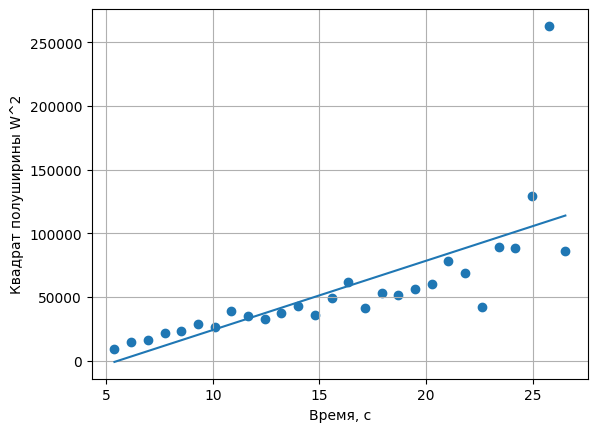

In [6]:
all_pic_w2 = []
for i in range(len(norm_data)):
    all_pic_w2.append(round(float(find_fwhm(norm_data[i])) ** 2, 2))
#print(all_pic_w2)

time_start, time_end = map(float, input('Введите время с первого изображение и с последнего через пробел: ').split())
time = np.linspace(time_start, time_end, len(all_pic_w2))

p = np.polyfit(time, all_pic_w2, 1)
print('Slope = ', round(p[0], 2))
ya = np.polyval(p, time)

plt.scatter(time, all_pic_w2)
plt.plot(time, ya)
plt.xlabel('Время, с')
plt.ylabel('Квадрат полуширины W^2')
plt.grid()
plt.show()

In [8]:
from math import pi

def size_of_particle(slope):
    t = int(input('Введите температуру в помещении в Кельвинах: '))
    radius = (1.38*t/(6*pi*0.01*(slope/8)))/10
    return radius

print('r = ', round(size_of_particle(p[0]), 5), " nm")

Введите температуру в помещении в Кельвинах: 293
r =  0.31609  nm
